Experiment with computing 4-D covariance matrix instead of just 2-D projection

In [1]:
workdir = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/8-4dcovmat/'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/8-4dcovmat


# Tools

In [2]:
import mcvine.cli
from mcvine_workflow.singlextal.resolution import use_covmat, use_res_comps
import numpy as np, scipy.linalg
import histogram as H, histogram.hdf as hh

In [3]:
np

<module 'numpy' from '/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/numpy/__init__.pyc'>

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

# Sample

In [5]:
%%file Si.yml
name: Si
chemical_formula: Si2
lattice: 
 constants: 5.490700041, 5.490700041, 5.490700041, 90, 90, 90
 basis_vectors:
  - 5.490700041, 0, 0
  - 0, 5.490700041, 0
  - 0, 0, 5.490700041
 primitive_basis_vectors:
  - 0.0, 2.71526503565, 2.71526503565
  - 2.71526503565, 0.0, 2.71526503565
  - 2.71526503565, 2.71526503565, 0.0
excitations:
 - type: DGSresolution
orientation:
 u: -1, 1, -1
 v: 2, 1, -1
shape: block width="2*inch" height="4.*inch" thickness="1*mm"
temperature: 100*K

Overwriting Si.yml


In [6]:
sampleyml = "Si.yml"

# Instrument

In [7]:
instrument = use_covmat.instrument(
    name = 'ARCS',
    detsys_radius = "3.*meter",
    L_m2s = "13.6*meter",
    L_m2fc = "11.61*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_covmat.pixel(
    radius = "0.5*inch",
    height = "meter/128",
    pressure = "10*atm",
    )

# Experiment

In [8]:
'''
Ei = 126
class dynamics:
    hkl0 = [-8.21,-0,0]
    hkl_dir = np.array([1.,0.,0.])
    E = 7.8
    dq = 0
class scan:
    min, max, step = -5, 90., 0.5
'''

Ei = 126
class dynamics:
    hkl0 = [-4.56,-0,0]
    hkl_dir = np.array([1.,0.,0.])
    E = 62.5
    dq = 0
class scan:
    min, max, step = -5, 90., 0.5

In [9]:
from mcni.utils import conversion as Conv

# Use Cov Mat

In [10]:
from mcvine_workflow.singlextal.io import loadXtalOriFromSampleYml
xtalori = loadXtalOriFromSampleYml(sampleyml)
from mcvine_workflow.singlextal.coords_transform import hkl2Q
xtalori.psi = 0
hkl2Q = xtalori.hkl2cartesian_mat()
print np.dot([-1., 1, -1], hkl2Q)
print np.dot(hkl2Q, [-1., 1, -1])

[  1.98204165e+00  -5.55111512e-17   1.11022302e-16]
[ 1.59502395  0.61565626  1.00267397]


psi=0, u along beam.

So we know Q = hkl dot hkl2Q
and Q is in the convention that x axis is along beam

In [11]:
def compute(
        sample_yml, Ei, dynamics, psi_scan, instrument, pixel, tofwidths, beamdivs, samplethickness,
        plot=False):
    print "XXXXXXXXXXXXXXXXXXXXXXX"
    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    # should P be the T0 chopper?
    L_PM=mcvine.units.parse(instrument.L_m2fc)/mcvine.units.meter # P chopper to M chopper distance
    L_PS= mcvine.units.parse(instrument.L_m2s)/mcvine.units.meter  # P chopper to sample
    L_MS=L_PS-L_PM
    #
    R = mcvine.units.parse(instrument.detsys_radius)/mcvine.units.meter # 

    hkl0 = dynamics.hkl0
    hkl_dir = dynamics.hkl_dir # projection
    psimin = psi_scan.min
    psimax = psi_scan.max
    dpsi = psi_scan.step

    # dynamics calculations
    E = dynamics.E
    dq = dynamics.dq
    hkl = hkl0 + dq*hkl_dir

    from mcni.utils import conversion as Conv
    vi = Conv.e2v(Ei)

    ti = L_PM/vi*1e6 # microsecond
    Ef = Ei - E
    vf = Conv.e2v(Ef)

    # find the psi angle
    from mcvine_workflow.singlextal.io import loadXtalOriFromSampleYml
    xtalori = loadXtalOriFromSampleYml(sample_yml)
    from mcvine_workflow.singlextal.solve_psi import solve
    print Ei, hkl, E, psimin, psimax
    results = solve(
        xtalori, Ei, hkl, E, psimin, psimax,
        Nsegments = 10)
#        Nsegments = 100)
    from mcvine_workflow.singlextal.coords_transform import hkl2Q
    for r in results:
        xtalori.psi = r*np.pi/180
        print "psi=%s, Q=%s" % (r, hkl2Q(hkl, xtalori))
        print "hkl2Q=%r\n(Q = hkl dot hkl2Q)" % (xtalori.hkl2cartesian_mat(),)
    # these are the psi angles that the particular point of interest will be measured
    # print results
    assert len(results)
    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    # only select the first one. this is OK for most cases but there are cases where more than
    # one psi angles satisfy the condition
    psi = results[0]
    print "psi=%s degree" % psi
    xtalori.psi = psi*np.pi/180
    print "psi=%s radian" % xtalori.psi
    Q = hkl2Q(hkl, xtalori)
    hkl2Q_mat = xtalori.hkl2cartesian_mat()
    # print Q
    # print "hkl2Q_mat=", hkl2Q_mat
    #
    Q_len = np.linalg.norm(Q); print Q_len
    ki = Conv.e2k(Ei); print ki
    kiv = np.array([ki, 0, 0])
    kfv = kiv - Q; print kfv
    #
    # ** Verify the momentum and energy transfers **
    # print Ei-Conv.k2e(np.linalg.norm(kfv))
    # print Ei-Ef
    assert np.isclose(Ei-Ef, E)

    # ** Compute detector pixel position **
    z = kfv[2]/(kfv[0]**2+kfv[1]**2)**.5 * R
    L_SD=(z**2+R**2)**.5
    # print z, L_SD

    # ### Constants
    eV = 1.60218e-19
    meV = eV*1e-3
    mus = 1.e-6
    hbar= 1.0545718e-34
    AA = 1e-10
    m = 1.6750e-24 * 1e-3 #kg
    from numpy import sin, cos

    # dE calcuation starts here
    # ## Differentials
    pE_pt = -m*(vi**3/L_PM + vf**3/L_SD * L_MS/L_PM)
    # convert to eV/microsecond
    pE_pt /= meV/mus
    # print pE_pt

    pE_ptMD = m*vf**3/L_SD
    pE_ptMD /= meV/mus
    # print pE_ptMD

    pE_pLPM = m/L_PM * (vi**2 + vf**3/vi * L_MS/ L_SD)
    pE_pLPM /= meV
    # print pE_pLPM

    pE_pLMS= -m/L_SD * (vf**3/vi)
    pE_pLMS /= meV
    # print pE_pLMS

    pE_pLSD = -m*vf*vf/L_SD
    pE_pLSD /= meV
    # print pE_pLSD

    # we don't need pE_pLSD, instead we need pE_pR and pE_pz. R and z are cylinder radius and z coordinate
    pE_pR = pE_pLSD * (R/L_SD)
    pE_pz = pE_pLSD * (z/L_SD)
    # print pE_pR, pE_pz

    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    # ## ** Paramters: Estimate of standard deviations
    # tau_P = 10 # microsecond
    # tau_M = 8 # microsecond
    tau_P = tofwidths.P
    tau_M = tofwidths.M
    #
    # tau_D = 10 # microsecond
    tau_D = mcvine.units.parse(pixel.radius)/mcvine.units.meter*2/vf*1e6 # microsecond

    # ## Calculations
    pE_p_vec = [pE_pt, pE_ptMD, pE_pLPM, pE_pLMS, pE_pR, pE_pz]
    pE_p_vec = np.array(pE_p_vec)
    J_E = pE_p_vec/E

    # print J_E
    sigma_t = (tau_P**2+tau_M**2)**.5
    sigma_tMD = (tau_M**2+tau_D**2)**.5
    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    div = (beamdivs.theta**2 + beamdivs.phi**2)**.5  # a crude approx
    sigma_LPM = L_PM * div*div

    # mainly due to sample size
    sigma_LMS = samplethickness

    # mainly due to det tube diameter
    sigma_R = mcvine.units.parse(pixel.radius)/mcvine.units.meter*2

    # pixel size
    sigma_z = mcvine.units.parse(pixel.height)/mcvine.units.meter

    sigma = np.array([sigma_t, sigma_tMD, sigma_LPM, sigma_LMS, sigma_R, sigma_z])
    # print sigma
    sigma2 = sigma*sigma
    # print sigma2
    sigma2 = np.diag(sigma2)

    # print J_E
    # print np.dot(sigma2, J_E)
    cov = np.dot(J_E, np.dot(sigma2, J_E))

    # print cov, np.sqrt(cov)
    sigma_E = E*np.sqrt(cov)
    # print sigma_E

    # Not sure if this is right:
    # 
    # * ** Note: this may be more like FWHM than sigma_E because of the approx I made **
    # * ** FWHM is 2.355 sigma **

    # ## Include Q
    print "ti=",ti
    tf = L_SD/vf*1e6; print "tf=",tf
    thetai = 0
    phii = 0
    print "R=", R
    print "Q=", Q

    eeta = np.arctan2(kfv[1], kfv[0])
    print "eeta=", eeta

    pQx_pt = -m/hbar*(L_PM/ti/ti/mus/mus*cos(thetai)*cos(phii)
                      +R/tf/tf/mus/mus*L_MS/L_PM*cos(eeta))
    pQx_pt/=1./AA/mus
    # print pQx_pt

    pQx_ptMD = m/hbar * R/tf/tf * cos(eeta) / mus/mus
    pQx_ptMD /= 1./AA/mus
    # print pQx_ptMD

    pQx_pLPM = m/hbar *(cos(thetai) * cos(phii)/ti + ti/tf/tf * R*L_MS/L_PM/L_PM * cos(eeta)) / mus
    pQx_pLPM /= 1./AA
    # print pQx_pLPM

    pQx_pLMS = -m/hbar * R/tf/tf*ti/L_PM*cos(eeta) / mus
    pQx_pLMS /= 1./AA
    # print pQx_pLMS

    pQx_pR = -m/hbar/tf*cos(eeta) / mus
    pQx_pR /= 1./AA
    # print pQx_pR

    pQx_peeta = m/hbar * R/tf*sin(eeta) /mus
    pQx_peeta /= 1./AA
    # print pQx_peeta

    pQx_pthetai = -m/hbar*L_PM/ti*sin(thetai)*cos(phii)/mus
    pQx_pthetai/=1./AA
    # print pQx_pthetai

    pQx_pphii = -m/hbar*L_PM/ti*cos(thetai)*sin(phii)/mus
    pQx_pphii/=1./AA
    # print pQx_pphii

    pQx_p_vec = [pQx_pt, pQx_ptMD, pQx_pLPM, pQx_pLMS, pQx_pR, 0, pQx_peeta, pQx_pthetai, pQx_pphii]
    pQx_p_vec = np.array(pQx_p_vec)
    J_Qx = pQx_p_vec/Q_len

    # **Qy**
    pQy_pt = -m/hbar*(L_PM/ti/ti*sin(thetai)*cos(phii)+R/tf/tf*L_MS/L_PM*sin(eeta))/mus/mus
    pQy_pt/=1./AA/mus
    # print pQy_pt

    pQy_ptMD = m/hbar * R/tf/tf * sin(eeta) / mus/mus
    pQy_ptMD /= 1./AA/mus
    # print pQy_ptMD

    pQy_pLPM = m/hbar *(sin(thetai) * cos(phii)/ti 
                        + ti/tf/tf * R*L_MS/L_PM/L_PM * sin(eeta)) / mus
    pQy_pLPM /= 1./AA
    # print pQy_pLPM

    pQy_pLMS = -m/hbar * R/tf/tf*ti/L_PM*sin(eeta) / mus
    pQy_pLMS /= 1./AA
    # print pQy_pLMS

    pQy_pR = -m/hbar/tf*sin(eeta) / mus
    pQy_pR /= 1./AA
    # print pQy_pR

    pQy_peeta = -m/hbar * R/tf*cos(eeta) /mus
    pQy_peeta /= 1./AA
    # print pQy_peeta

    pQy_pthetai = m/hbar*L_PM/ti*cos(thetai)*cos(phii)/mus
    pQy_pthetai/=1./AA
    # print pQy_pthetai

    pQy_pphii = -m/hbar*L_PM/ti*sin(thetai)*sin(phii)/mus
    pQy_pphii/=1./AA
    # print pQy_pphii

    pQy_p_vec = [pQy_pt, pQy_ptMD, pQy_pLPM, pQy_pLMS, pQy_pR, 0, pQy_peeta, pQy_pthetai, pQy_pphii]
    pQy_p_vec = np.array(pQy_p_vec)
    J_Qy = pQy_p_vec/Q_len

    # ** Qz **
    pQz_pt = -m/hbar*(L_PM/ti/ti*sin(phii)+z/tf/tf*L_MS/L_PM)/mus/mus
    pQz_pt/=1./AA/mus
    # print pQz_pt

    pQz_ptMD = m/hbar * z/tf/tf /mus/mus
    pQz_ptMD /= 1./AA/mus
    # print pQz_ptMD

    pQz_pLPM = m/hbar *(sin(phii)/ti + ti/tf/tf * z*L_MS/L_PM/L_PM) / mus
    pQz_pLPM /= 1./AA
    # print pQz_pLPM

    pQz_pLMS = -m/hbar * z/tf/tf*ti/L_PM / mus
    pQz_pLMS /= 1./AA
    # print pQz_pLMS

    pQz_pz = -m/hbar/tf / mus
    pQz_pz/=1./AA
    # print pQz_pz

    pQz_pphii = m/hbar*L_PM/ti*cos(phii)/mus
    print "m,hbar,L_PM,ti,phii,mus=", m,hbar,L_PM,ti,phii,mus
    pQz_pphii/=1./AA
    print "pQz_pphii=", pQz_pphii

    pQz_p_vec = [pQz_pt, pQz_ptMD, pQz_pLPM, pQz_pLMS, 0, pQz_pz, 0, 0, pQz_pphii]
    pQz_p_vec = np.array(pQz_p_vec)
    J_Qz = pQz_p_vec/Q_len

    # ** Here we need to extend the J vector for E to include the additional variables eeta, thetai, and phii **
    pE_p_vec = [pE_pt, pE_ptMD, pE_pLPM, pE_pLMS, pE_pR, pE_pz,0,0,0]
    pE_p_vec = np.array(pE_p_vec)
    J_E = pE_p_vec/E
    J = np.array( (J_Qx, J_Qy, J_Qz, J_E) )
    print "J="
    print J

    # ## ** Parameters
    sigma_eeta = mcvine.units.parse(pixel.radius)/mcvine.units.parse(instrument.detsys_radius)
    # sigma_thetai = 0.01
    sigma_thetai = beamdivs.theta
    # sigma_phii = 0.01
    sigma_phii = beamdivs.phi
    sigma = np.array([sigma_t, sigma_tMD, sigma_LPM, sigma_LMS, sigma_R, sigma_z, sigma_eeta, sigma_thetai, sigma_phii])
    sigma2 = sigma**2
    sigma2 = np.diag(sigma2)
    
    # try making sigma2 not diagonal
    #sigma2[0][1] = 50
    #sigma2[1][0] = 50

    # print J.shape, sigma2.shape
    cov = np.dot(J, np.dot(sigma2, J.T))
    print 'cov=', cov

    M = np.linalg.inv(cov)
    print 'M=', M

    print "This should be I:", np.dot(cov, M)

    # ## Ellipsoid
    # hkl = hkl0+hkl_dir*x
    # dh,dk,dl = dx2dhkl*dx 
    dx2dhkl = np.array(hkl_dir)
    print "dx2dhkl=", dx2dhkl
    # dQ = dx * dx2dhkl dot hkl2Q
    # so dx2dQ = dx2dhkl * hkl2Q
    # dQ = dx * dx2dQ
    dx2dQ = np.dot(dx2dhkl, hkl2Q_mat)
    print "hkl2Q_mat=", hkl2Q_mat
    print "dx2dQ=", dx2dQ

    # [dQx,dQy,dQz,dE] = [dx dE] dot dxdE2dQdE
    L=dxdE2dQdE = np.array([list(dx2dQ) + [0],  
                            [ 0.        ,  0.,          0.,  1]
                            ])
    print "L=", L

    np.dot([1,1], dxdE2dQdE)

    # $ [dX1,\; dX2,\; dX3,\; dX4]\; M\; [dX1,\; dX2,\; dX3,\; dX4 ]^T = 2ln(2)$
    # 
    # $ dX_i = \frac{dQ_i}{|Q|}$ for i = 1,2,3
    # 
    # $ dX_4 = \frac{dE}{E}$
    # 
    # Let 
    # $ U = diag\big( \frac{1}{|Q|},\; \frac{1}{|Q|},\; \frac{1}{|Q|},\; 1/E \big) $
    # 
    # $ [dx,\; dE]\; L U MU^TL^T [dx,\; dE ]^T = 2ln(2)$
    # 
    # Let $N=L U MU^TL^T $
    # print Q_len, E
    U = np.diag([1./Q_len, 1./Q_len, 1./Q_len, 1./E])
    
    # Make 4-D inverse covariance matrix:
    InvCov4D = UMUT = np.dot(U, np.dot(M, U.T))
    hklE2QE = scipy.linalg.block_diag(hkl2Q_mat, 1.)
    InvCov4D = np.dot(np.dot(hklE2QE, InvCov4D), hklE2QE.T)
    
    # Make 2-D projection covariance matrix
    N = LUMUTLT = np.dot(L, np.dot(U, np.dot(M, np.dot(U.T, L.T))))
    print "N=",N
    # print 2*np.log(2)
    r = np.linalg.eig(N)
    mR = r[1]; lambdas = r[0]
    # print np.dot(mR, mR.T)
    np.dot(np.dot(mR.T, N), mR)

    # $ u = [dx,\;dE]$
    # 
    # $ u N u^T = 2ln(2)$        .... (1)
    # 
    # Find eigen values ($\lambda_1$, $\lambda_2$) and eigne vectors ($e_1$, $e_2$, column vectors) of N,
    # and let 
    # 
    # $ R = [e_1,\;e_2] $
    # 
    # Then
    # 
    # $ N' = R^T N R = diag([\lambda_1, \lambda_2]) $
    # 
    # or
    # 
    # $ N = R N' R^T $
    # 
    # With $N'$ we can rewrite (1) as
    # 
    # $ u'N'{u'}^T = 2ln2 = \lambda_1 {u'}_1^2 + \lambda_2 {u'}_2^2 $
    # 
    # where
    # 
    # $ u' = u . R $

    # ${u'}_1 = \sqrt{2ln2/\lambda_1}*cos(\theta)$
    # 
    # ${u'}_2 = \sqrt{2ln2/\lambda_2}*sin(\theta)$

    # In[ ]:

    RR = 2*np.log(2)
    theta = np.arange(0, 360, 1.)*np.pi/180
    u1p = np.sqrt(RR/lambdas[0])*np.cos(theta)
    u2p = np.sqrt(RR/lambdas[1])*np.sin(theta)
    up = np.array([u1p, u2p]).T

    # print up.shape
    u = np.dot(up, mR.T)

    if plot:
        from matplotlib import pyplot as plt
        plt.plot(u[:,0], u[:,1], '.')
        # plt.xlim(-.35, .1)
        # plt.ylim(-5., 5.)
        plt.show()
    # ellipsoid coordinates, eigen vectors and eigen values of the scaled inverse covariance
    return dict(u=u, mR=mR, lambdas=lambdas, cov=cov, InvCov4D=InvCov4D)

XXXXXXXXXXXXXXXXXXXXXXX
126 [-4.56  0.    0.  ] 62.5 -5 90.0
psi=9.58267562396, Q=[ 3.67993095 -3.69962862  0.        ]
hkl2Q=array([[-0.8070024 ,  0.81132207,  0.        ],
       [ 0.57369133,  0.57063687, -0.80916512],
       [-0.57369133, -0.57063687, -0.80916512]])
(Q = hkl dot hkl2Q)
psi=9.58267562396 degree
psi=0.167249240789 radian
5.21815520549
7.79789939468
[ 4.11796844  3.69962862  0.        ]
ti= 2364.69322632
tf= 860.72070896
R= 3.0
Q= [ 3.67993095 -3.69962862  0.        ]
eeta= 0.7319365711
m,hbar,L_PM,ti,phii,mus= 1.675e-27 1.0545718e-34 11.61 2364.69322632 0 1e-06
pQz_pphii= 7.79823053697
J=
[[ -7.89141741e-04   9.16900505e-04   1.60730244e-01  -1.86751801e-01
   -2.63065084e-01   0.00000000e+00   7.09021787e-01  -0.00000000e+00
   -0.00000000e+00]
 [ -1.41194632e-04   8.23753605e-04   2.87581386e-02  -1.67779894e-01
   -2.36340596e-01   0.00000000e+00  -7.89195252e-01   1.49444205e+00
   -0.00000000e+00]
 [ -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000

/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/solve_psi.py:55: UserWarning: Traceback (most recent call last):
  File "/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/solve_psi.py", line 52, in solve
    results.append(solver(res, min, max))
  File "/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/scipy/optimize/zeros.py", line 442, in brentq
    r = _zeros._brentq(f,a,b,xtol,rtol,maxiter,args,full_output,disp)
ValueError: f(a) and f(b) must have different signs

  warnings.warn(tb.format_exc())


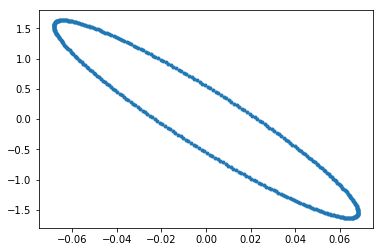

CPU times: user 396 ms, sys: 624 ms, total: 1.02 s
Wall time: 407 ms


In [12]:
%%time
tofwidths = use_covmat.tofwidths(P=10, M=8)
beamdivs = use_covmat.beamdivs(theta=0.01, phi=0.01)
samplethickness = 0.001
# ellipsoid_trace, mR, lambdas = use_covmat.compute(
cm_res = compute(
    sampleyml, Ei, dynamics, scan,
    instrument, pixel,
    tofwidths, beamdivs, samplethickness,
    plot=True)
ellipsoid_trace = cm_res['u']
InvCov4D = cm_res['InvCov4D']

In [13]:
print InvCov4D

[[ 2630.71088436 -1858.85890621  1858.85890621   103.50157057]
 [-1858.85890621  1603.74008421 -1395.52266461   -81.40252438]
 [ 1858.85890621 -1395.52266461  1603.74008421    81.40252438]
 [  103.50157057   -81.40252438    81.40252438     4.59174042]]


# Use Res Comps

In [14]:
!which mcvine

/SNS/software/miniconda2/envs/mcvine-unstable/bin/mcvine


In [15]:
!mcvine-neutron-storage-count-neutrons /SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9/out/neutrons

240459


In [16]:
!pwd

/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/8-4dcovmat


In [17]:
rm -rf out.res_comps_tmp/

In [18]:
beam = "/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9"
psi_axis = scan
use_res_comps.setup(
    'out.res_comps_tmp', sampleyml, beam, dynamics.E, dynamics.hkl0, dynamics.hkl_dir,
    psi_axis, instrument, pixel)

Ei=126.211753632, t0=16.0728240277
Computed:
* psi=9.53486687503 degree
* Q=[ 3.67684263 -3.70269794  0.        ]
* hkl2Qmat=[[-0.80632514  0.81199516  0.        ]
 [ 0.57416729  0.57015797 -0.80916512]
 [-0.57416729 -0.57015797 -0.80916512]]
* ki=7.80444915794
* vectors ki=[ 7.80444916  0.          0.        ], kf=[ 4.12760653  3.70269794  0.        ]
These two numbers should be very close:
  62.5
  62.5
  Ei=126.211753632, Ef=63.711753632
* Ef=63.711753632
* pixel positon=[ 2.23314751  2.00326039  0.        ]
* pixel_position=[ 2.23314751  2.00326039  0.        ]
t_m2s=0.00278375914959, t_s2p=0.000859289164391, t_m2p=0.00364304831398


In [19]:
ls out.res_comps_tmp/

run.py  sample/


In [20]:
cat out.res_comps_tmp/run.py

#!/usr/bin/env python
import mcvine.cli
from numpy import array
from mcvine_workflow.singlextal.resolution import use_res_comps as urc
beam_neutrons_path = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9/out/neutrons'
instrument = urc.instrument('ARCS', '3.*meter', '13.6*meter', '-0.15*meter')
samplexmlpath = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/8-4dcovmat/out.res_comps_tmp/sample/sampleassembly.xml'
psi = 0.16641482070853725
hkl2Q = array([[-0.80632514,  0.81199516,  0.        ],
       [ 0.57416729,  0.57015797, -0.80916512],
       [-0.57416729, -0.57015797, -0.80916512]])
pp = array([ 2.23314751,  2.00326039,  0.        ])
pixel = urc.pixel('0.5*inch', 'meter/128', '10*atm', position=(pp[1], pp[2], pp[0]))
t_m2p = 0.003643048313977743
Q = array([ 3.67684263, -3.70269794,  0.        ])
E = 62.5
hkl_projection = array([ 1.,  0.,  0.])
urc.run(
    beam_neutrons_path, instrument, samplexmlpath, psi, 

In [21]:
%%time
%cd {workdir}/out.res_comps_tmp/
!python run.py >log.run
%cd {workdir}

/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/8-4dcovmat/out.res_comps_tmp
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/SimulationContext.py:39: UserWarning: output directory was not set
  warnings.warn("output directory was not set")
/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/8-4dcovmat
CPU times: user 573 ms, sys: 181 ms, total: 755 ms
Wall time: 27.7 s


In [22]:
ls out.res_comps_tmp/

dEs.npy  dhkls.npy  dxs.npy  log.run  probs.npy  res.h5  run.py  sample/


## Get mcvine-simulated data

In [23]:
dhkls = np.load('out.res_comps_tmp/dhkls.npy')
dEs = np.load('out.res_comps_tmp/dEs.npy')
probs = np.load('out.res_comps_tmp/probs.npy')

In [24]:
dhs,dks,dls = dhkls.T

Compute MCViNE 4-D (inverse) covariance matrix

In [25]:
print len(dhs)
dhs_np = np.array(dhs)
dks_np = np.array(dks)
dls_np = np.array(dls)
dEs_np = np.array(dEs)
print type(dhs_np)
Data = np.array([dhs_np, dks_np, dls_np, dEs_np])
print type(Data)
print np.shape(Data)

print np.shape(probs)

115366
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(4, 115366)
(115366,)


In [26]:
logprobs = np.log(1+probs)

In [27]:
I, edges = np.histogram(logprobs)

(0, 900)

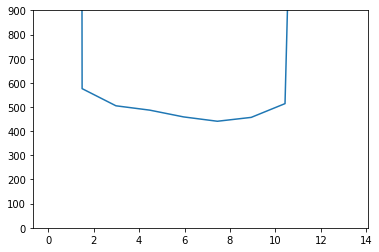

In [28]:
plt.plot(edges[:-1], I)
plt.ylim(0, 900)

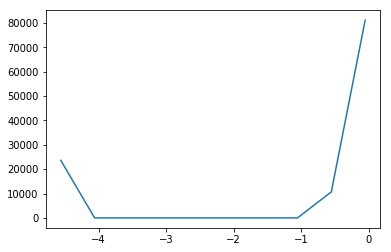

In [29]:
I, edges = np.histogram(dhs_np)
plt.plot(edges[:-1], I)
# plt.ylim(0, 900)

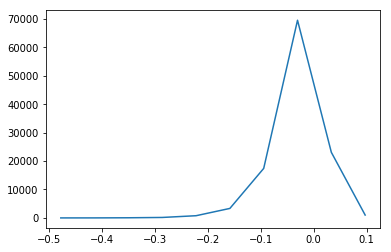

In [30]:
I, edges = np.histogram(dks_np)
plt.plot(edges[:-1], I)
# plt.ylim(0, 900)

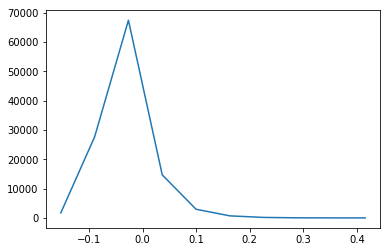

In [31]:
I, edges = np.histogram(dls_np)
plt.plot(edges[:-1], I)
# plt.ylim(0, 900)

In [32]:
mask = dhs_np> -2.

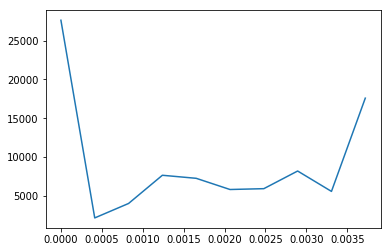

In [33]:
probs1 = probs[mask]
logprobs1 = np.log(1+probs1)
I, edges = np.histogram(logprobs1)
plt.plot(edges[:-1], I)
# plt.ylim(0, 900)

In [34]:
Data = np.array([dhs_np[mask], dks_np[mask], dls_np[mask], dEs_np[mask]])

In [35]:
# mcvine_cov = np.cov(Data)
mcvine_cov = np.cov(Data, aweights=probs[mask])

# Compare covariance matrices
print "Covariance Method: (Inverse covariance)"
print InvCov4D
print "MCViNE: (Inverse covariance method)"
print np.linalg.inv(mcvine_cov)

Covariance Method: (Inverse covariance)
[[ 2630.71088436 -1858.85890621  1858.85890621   103.50157057]
 [-1858.85890621  1603.74008421 -1395.52266461   -81.40252438]
 [ 1858.85890621 -1395.52266461  1603.74008421    81.40252438]
 [  103.50157057   -81.40252438    81.40252438     4.59174042]]
MCViNE: (Inverse covariance method)
[[ 2303.62046608 -2483.10049309  2470.19388222   114.01140568]
 [-2483.10049309  4901.47575155 -4261.67523598  -186.75825773]
 [ 2470.19388222 -4261.67523598  4877.96694127   186.24131453]
 [  114.01140568  -186.75825773   186.24131453     7.94348123]]


In [36]:
# remove outliers

# plot distribution of probabilities to get an idea of any outliers
#plt.plot(probs, np.zeros_like(probs), 'x')
sorted_probs = np.sort(probs)
#plt.plot(sorted_probs, np.zeros_like(sorted_probs), 'x')
min_prob = sorted_probs[0]
max_prob = sorted_probs[-1]
manual_bin_boundaries = [min_prob]
num = 10
increment = (1. / num) * (max_prob - min_prob)
bin_instances = []
least_instance = 0
for i in range(10):
    boundary = manual_bin_boundaries[-1] + increment
    manual_bin_boundaries.append(boundary)
    
    # count number of occurrences within each bin
    instances = 0
    while (sorted_probs[least_instance] < boundary):
        instances += 1
        least_instance += 1
    bin_instances.append(instances)
    
manual_bin_boundaries = np.array(manual_bin_boundaries)
bin_instances = np.array(bin_instances)

manual_bin_centers = (manual_bin_boundaries[:-1] + manual_bin_boundaries[1:]) / 2.0
plt.bar(manual_bin_centers, bin_instances, align='center', width=0.7*increment)
print "min_prob = " + str(min_prob) + ", max_prob = " + str(max_prob)
print "manual_bin_boundaries = " + str(manual_bin_boundaries)
hist, bins = np.histogram(sorted_probs, bins=10)
visual_width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2.0
#plt.bar(center, hist, align='center', width=visual_width)
#plt.hist(sorted_probs, bins='auto')


# try only using points with prob weights less than 500,000
cleaned_probs = np.copy(probs)
for i in range(len(probs)):
    if probs[i] > 500000:
        cleaned_probs[i] = 0.0


# we must debug:  there is some huge intensity value which is throwing everything off
maxelement = np.max(probs)
#print maxelement
maxindex = np.where(probs == maxelement)
print maxindex
m1 = maxindex[0][0]
print m1


#withoutmax = np.copy()
cleaned_probs = np.copy(probs)
cleaned_probs[m1] = 0.0
maxelement2 = np.max(cleaned_probs)
m2 = np.where(cleaned_probs == maxelement2)
m2 = m2[0][0]
print m2

print "maxelement = " + str(maxelement) + ", maxelement2 = " + str(maxelement2)

# remove erroneous max element if it exists
if np.fabs(maxelement - maxelement2) > 0.1*maxelement2:
    probs = cleaned_probs
#else:
    # do nothing

#mcvine_cov = np.cov(Data, aweights=probs)
mcvine_cov = np.cov(Data)
#mcvine_cov = np.cov(Data, aweights=cleaned_probs)

# Compare covariance matrices
print "Covariance Method: (Inverse covariance)"
print InvCov4D
print "MCViNE: (Inverse covariance method)"
print np.linalg.inv(mcvine_cov)

IndexError: index 115366 is out of bounds for axis 0 with size 115366

## get slice of resolution 

In [ ]:
mask=(dls<0.02)*(dls>-0.02)*(dks<0.02)*(dks>-0.02)

hist, qedges, Eedges = np.histogram2d(
    x=dhs[mask], y=dEs[mask], bins=(np.arange(-1, 1, 0.002), np.arange(-15,8,0.1)), weights=probs[mask])

qaxis = H.axis('q', boundaries=qedges)
Eaxis = H.axis('E', boundaries=Eedges)
IqE = H.histogram('IqE', (qaxis, Eaxis), data=hist)

In [ ]:
H.plot(IqE)

In [ ]:
qgrid, Egrid = np.mgrid[
    IqE.q[0] : IqE.q[-1]+1e-10 : IqE.q[1]-IqE.q[0],
    IqE.E[0] : IqE.E[-1]+1e-10 : IqE.E[1]-IqE.E[0]
]
plt.pcolormesh(qgrid, Egrid, IqE.I)
plt.clim(0, 1e-2)
plt.plot(ellipsoid_trace[:,0], ellipsoid_trace[:,1])

# Plot along xyz directions

In [ ]:
%%time
"""
tofwidths = use_covmat.tofwidths(P=10, M=2)
beamdivs = use_covmat.beamdivs(theta=0.05, phi=0.05)
samplethickness = 0.0001
instrument = use_covmat.instrument(
    name = 'ARCS',
    detsys_radius = "3.*meter",
    L_m2s = "11.7*meter",
    L_m2fc = "11.61*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_covmat.pixel(
    radius = "0.5*inch",
    height = "meter/128",
    pressure = "10*atm",
    )
"""
unit_vectors = [[1,0,0], [0,1,0], [0,0,1]]
axes = 'hkl'

traces = []
IqEs = []
for axis_index, uv in enumerate(unit_vectors):
    dynamics.hkl_dir = np.array(uv)
    # ellipsoid_trace, mR, lambdas = use_covmat.compute(
    cm_res = compute(
        sampleyml, Ei, dynamics, scan,
        instrument, pixel,
        tofwidths, beamdivs, samplethickness,
        plot=False)
    ellipsoid_trace = cm_res['u']
    traces.append(ellipsoid_trace)
    
    mask = True
    for axis_index2, axis in enumerate(axes):
        if axis_index2==axis_index: continue # skip the axis of interest
        # print "d%ss<0.02"%axis, "d%ss>-0.02"%axis
        mask *= eval("d%ss<0.002"%axis)*eval("d%ss>-0.002"%axis)
        continue
    # print mask.shape, mask.sum(), mask.dtype
    dqs = eval("d%ss" % axes[axis_index])
    hist, qedges, Eedges = np.histogram2d(
        x=dqs[mask], y=dEs[mask], bins=(np.arange(-1, 1, 0.002), np.arange(-15,8,0.1)), weights=probs[mask])
    # hist, qedges, Eedges = np.histogram2d(
    #    x=dqs, y=dEs, bins=(np.arange(-0.2, 0.2, 0.002), np.arange(-15,8,0.1)), weights=probs)
    qaxis = H.axis('q', boundaries=qedges)
    Eaxis = H.axis('E', boundaries=Eedges)
    # print hist.sum()
    IqE = H.histogram('IqE', (qaxis, Eaxis), data=hist)
    IqEs.append(IqE)
    continue

In [ ]:
plt.figure(figsize=(15, 5))
for i, (trace, IqE) in enumerate(zip(traces, IqEs)):
    plt.subplot(1, 3, i+1)
    qgrid, Egrid = np.mgrid[
        IqE.q[0] : IqE.q[-1]+1e-10 : IqE.q[1]-IqE.q[0],
        IqE.E[0] : IqE.E[-1]+1e-10 : IqE.E[1]-IqE.E[0]
    ]
    plt.pcolormesh(qgrid, Egrid, IqE.I)
    #plt.clim(0, 1e-1)
    plt.colorbar()
    plt.plot(trace[:,0], trace[:,1])
    plt.xlim(-0.2, 0.2)
    plt.ylim(-15, 7)